

# 🧠 What is Functional Connectivity (FC)?

**Functional connectivity (FC)** refers to the *statistical dependence between activity in different brain regions over time*.
In fMRI, we measure the **BOLD signal** across time for each voxel or region of interest (ROI). If two areas’ signals rise and fall together, they are said to be *functionally connected*.

⚠️ Key distinctions:

* **FC ≠ Structural connectivity** → not physical/anatomical wiring.
* **FC ≠ Effective connectivity** → not directionality or causality.
* **FC = Statistical co-fluctuation** (commonly measured with correlation).

FC is widely used to study **brain networks** both at rest (*resting-state FC*) and during tasks (*task-based FC, beta-series, PPI*).

---
## 🔹 Role of Fisher-Z, `arctanh`, and `tanh`

* **Problem with correlations (r):**
  Correlation coefficients $r$ are bounded between $-1$ and $+1$, and their distribution is **not normal**, especially near the edges (e.g. 0.9 vs 0.95 are not “equally spaced” as 0.1 vs 0.15).

* **Fisher Z-transform:**
  To make correlations more “normal” and suitable for averaging or statistical testing, we transform them:

  $$
  Z = \operatorname{arctanh}(r) = \frac{1}{2}\ln\frac{1+r}{1-r}
  $$

  * `np.arctanh(r)` does this in code.
  * After this transform, the values are **unbounded** (−∞ to +∞) and approximately normal.
  * This makes averaging across runs/subjects valid.

* **Back-transform with `tanh`:**
  If we want to report results back as correlations, we apply:

  $$
  r = \tanh(Z)
  $$

  * `np.tanh(Z)` in code.
  * This squashes values back into \[−1, +1].

👉 **Summary:**
`arctanh` → correlation → Z (better behaved for stats/averaging).
`tanh` → Z back → correlation (human-readable).
---

# 🔑 Workflow for Functional Connectivity in Nilearn

---

## **1. Preprocessing (Before FC)**

Why? fMRI signals are noisy — motion, physiology, scanner drift can all inflate spurious correlations.

Typical preprocessing (usually via **fMRIPrep** or equivalent):

* Slice timing correction
* Motion correction & realignment
* Spatial normalization → standard space
* Confound extraction:

  * **Motion regressors** (6 rigid-body + derivatives + squares)
  * **Physiological regressors** (WM/CSF signals or aCompCor)
  * **Scrubbing regressors** (high FD/DVARS volumes)
* *(Optional)* Band-pass filtering (0.01–0.1 Hz, especially in resting state).

📘 *Lesson:* preprocessing and confound regression strongly impact connectivity estimates.

---

## **2. Define Regions of Interest (ROIs) or Seeds**

Why? To compute connectivity, we must first decide **which regions or voxels to analyze**.

Options:

* **Atlas-based ROIs:** predefined parcellations (Harvard–Oxford, Schaefer, AAL).
* **Seeds (spherical):** centered on MNI coordinates, often chosen from GLM peaks or literature.

📘 *Lesson:* ROI choice determines the scale of your analysis: *network-level* (atlas) vs *hypothesis-driven* (seeds).

---

## **3. Extract Time Series**

Why? Each ROI must be summarized by a single representative signal.

Steps in Nilearn:

* Use `NiftiLabelsMasker` (for atlas) or `NiftiSpheresMasker` (for seeds).
* Apply confounds regression (motion, WM/CSF, scrubbing).
* Standardize and detrend signals.

📘 *Lesson:* time series extraction is where denoising happens → bad confounds = bad connectivity.

---

## **4. Compute Connectivity**

Why? To quantify relationships between time series.

### Approaches in Nilearn (`ConnectivityMeasure`):

* **Correlation:** Pearson’s r (most common).
* **Partial correlation:** controls for all other ROIs’ signals.
* **Covariance / Precision:** alternative metrics for network structure.

Two main strategies:

* **ROI-to-ROI matrix:** correlation between each pair of atlas regions.
* **Seed-to-voxel map:** correlation between one seed and every voxel.

### Fisher Z-transform

* Apply `arctanh(r)` to correlations.
* Makes distributions more normal for group-level statistics.
* Inverse transform with `tanh` for interpretability.

📘 *Lesson:* ROI-to-ROI → network structure; Seed-to-voxel → seed’s whole-brain network.

---

## **5. Thresholding & Inference**

Why? Not all correlations are meaningful.

Options:

* **Uncorrected cutoff** (e.g., |Z| > 0.3).
* **FDR correction** → controls expected false discoveries.
* **Cluster correction** → retain clusters above voxelwise threshold (e.g., Z > 3.1, k ≥ 10).
* **FWE correction** → strictest, controls family-wise error rate.

📘 *Lesson:* thresholding avoids reporting spurious networks.

---

## **6. Atlas-Guided “Connected Regions”**

Why? Seed-to-voxel maps are rich but hard to summarize.

Steps:

1. Threshold the seed map (e.g., FDR or cluster threshold).
2. Overlay with atlas parcellation.
3. Count suprathreshold voxels per region.
4. Rank regions and report as tables.

📘 *Lesson:* converts voxel maps into interpretable region-level findings.

---

## **7. Advanced Task-Based Connectivity**

Sometimes simple correlations are not enough: task demands can modulate connectivity.

### Approaches:

* **Beta-Series Connectivity (BSC):**

  * Fit a trial-wise GLM (one beta per trial).
  * Correlate trial betas across regions.
  * Captures *condition-specific* connectivity.

* **Psychophysiological Interaction (PPI):**

  * GLM with three regressors:

    1. Psychological (task regressor)
    2. Physiological (seed time series)
    3. Interaction (psych × phys)
  * Tests whether connectivity between seed and other voxels is modulated by task.

📘 *Lesson:* BSC is trial-by-trial; PPI is condition-modulated. Both extend FC beyond resting-style analysis.

---

## **8. Interpretation & Reporting**

Why? FC results are easily misinterpreted.

Guidelines:

* **Activation vs Connectivity:**

  * GLM = mean activation differences.
  * FC = temporal co-fluctuations.
* **Be transparent:**

  * Report thresholds/corrections.
  * Report preprocessing, confounds, TR, scan length.
  * Always state atlas/seed choice.
* **Avoid over-interpretation:**

  * Negative correlations especially depend on preprocessing (global signal regression).
  * FC ≠ causality.

📘 *Lesson:* FC is powerful but must be reported cautiously and reproducibly.

---

# ✅ Summary

Functional connectivity = *statistical co-fluctuation* of brain regions.

Pipeline:

1. **Preprocessing** (clean signals)
2. **ROI/Seed definition**
3. **Time series extraction**
4. **Connectivity computation** (ROI–ROI, seed–voxel)
5. **Thresholding** (FDR/cluster/FWE)
6. **Atlas-guided reporting**
7. **Advanced task-based FC** (BSC, PPI)
8. **Interpretation & transparency**

---



---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import thresholding
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix

## **Loade preproccessed data , events and confounds**

In [16]:
run1_path   = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\swarsub-02_task-flanker_run-1_bold.nii"
run2_path   = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\swarsub-02_task-flanker_run-2_bold.nii"

event1_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\sub-02_func_sub-02_task-flanker_run-1_events.tsv"
event2_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\sub-02_func_sub-02_task-flanker_run-2_events.tsv"

img1 = nib.load(run1_path)
img2 = nib.load(run2_path)

ev1  = pd.read_csv(event1_path, sep="\t")
ev2  = pd.read_csv(event2_path, sep="\t")

assert {'onset','duration','trial_type'}.issubset(ev1.columns)
assert {'onset','duration','trial_type'}.issubset(ev2.columns)

TR1 = float(img1.header.get_zooms()[3])
TR2 = float(img2.header.get_zooms()[3])

n_scans_1 = img1.shape[-1]
n_scans_2 = img2.shape[-1]

frame_times_1 = np.arange(n_scans_1) * TR1
frame_times_2 = np.arange(n_scans_2) * TR2

print("TR1, TR2:", TR1, TR2)
print("n_scans_1, n_scans_2:", n_scans_1, n_scans_2)
events1_clean = pd.DataFrame({
    'onset':    ev1['onset'].astype(float).values,
    'duration': ev1['duration'].astype(float).values if 'duration' in ev1.columns else np.ones(len(ev1))*1.0,
    'trial_type': ev1['Stimulus'].astype(str).str.strip().str.lower().values  # -> congruent / incongruent
}).sort_values('onset').reset_index(drop=True)

events2_clean = pd.DataFrame({
    'onset':    ev2['onset'].astype(float).values,
    'duration': ev2['duration'].astype(float).values if 'duration' in ev2.columns else np.ones(len(ev2))*1.0,
    'trial_type': ev2['Stimulus'].astype(str).str.strip().str.lower().values
}).sort_values('onset').reset_index(drop=True)

print("Run1 trial_type levels:", events1_clean['trial_type'].unique())
print("Run2 trial_type levels:", events2_clean['trial_type'].unique())
print("shape of the image1 :", img1.shape)
print("shape of the image2 :", img2.shape)
events1_clean.head()


TR1, TR2: 2.0 2.0
n_scans_1, n_scans_2: 146 146
Run1 trial_type levels: ['congruent' 'incongruent']
Run2 trial_type levels: ['congruent' 'incongruent']
shape of the image1 : (79, 95, 79, 146)
shape of the image2 : (79, 95, 79, 146)


,onset,duration,trial_type
0,0.0,2.0,congruent
1,10.0,2.0,incongruent
2,20.0,2.0,congruent
3,30.0,2.0,incongruent
4,40.0,2.0,incongruent


In [19]:
ev2

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond
0,0.0,2.0,incongruent_correct,0.763,correct,1,1,congruent,cond003
1,10.0,2.0,incongruent_correct,0.613,correct,2,1,incongruent,cond003
2,20.0,2.0,incongruent_correct,0.737,correct,1,1,congruent,cond003
3,32.0,2.0,incongruent_correct,0.869,correct,2,1,incongruent,cond003
4,44.0,2.0,congruent_correct,0.647,correct,2,1,incongruent,cond001
5,54.0,2.0,congruent_correct,0.595,correct,1,1,congruent,cond001
6,64.0,2.0,congruent_correct,0.509,correct,1,1,congruent,cond001
7,76.0,2.0,congruent_correct,0.545,correct,2,1,incongruent,cond001
8,88.0,2.0,congruent_correct,0.533,correct,2,1,incongruent,cond001
9,102.0,2.0,congruent_correct,0.495,correct,2,1,incongruent,cond001


In [3]:
rp1_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-1_bold.nii\rp_sub-02_task-flanker_run-1_bold.txt"
rp2_path = r"H:\ML.neuroimaging\teaching\S 11\flanker\sub-02_task-flanker_run-2_bold.nii\rp_sub-02_task-flanker_run-2_bold.txt"

# Load raw 6 motion params (SPM format)
mp1 = pd.read_csv(rp1_path, sep=r"\s+", header=None)
mp2 = pd.read_csv(rp2_path, sep=r"\s+", header=None)

mp1.columns = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
mp2.columns = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']

# Temporal derivatives (first difference)
deriv1 = mp1.diff().fillna(0); deriv1.columns = [c + '_derivative1' for c in mp1.columns]
deriv2 = mp2.diff().fillna(0); deriv2.columns = [c + '_derivative1' for c in mp2.columns]

# Squares of originals and derivatives
p2_1 = (mp1**2); p2_1.columns = [c + '_power2' for c in mp1.columns]
p2_2 = (mp2**2); p2_2.columns = [c + '_power2' for c in mp2.columns]

d2_1 = (deriv1**2); d2_1.columns = [c + '_power2' for c in deriv1.columns]
d2_2 = (deriv2**2); d2_2.columns = [c + '_power2' for c in deriv2.columns]

# Concatenate → 24HMP
conf1 = pd.concat([mp1, deriv1, p2_1, d2_1], axis=1)
conf2 = pd.concat([mp2, deriv2, p2_2, d2_2], axis=1)

# Coerce numeric strictly (anything non-numeric becomes NaN)
conf1 = conf1.apply(pd.to_numeric, errors='coerce')
conf2 = conf2.apply(pd.to_numeric, errors='coerce')

# PAD to match image length (fill missing rows with 0s)
n_scans_1 = img1.shape[-1]
n_scans_2 = img2.shape[-1]

conf1 = conf1.reindex(range(n_scans_1)).fillna(0).reset_index(drop=True)
conf2 = conf2.reindex(range(n_scans_2)).fillna(0).reset_index(drop=True)

print("conf1 shape:", conf1.shape, "NaNs:", int(conf1.isna().to_numpy().sum()))
print("conf2 shape:", conf2.shape, "NaNs:", int(conf2.isna().to_numpy().sum()))
conf1.head(3)

conf1 shape: (146, 24) NaNs: 0
conf2 shape: (146, 24) NaNs: 0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,...,trans_z_power2,rot_x_power2,rot_y_power2,rot_z_power2,trans_x_derivative1_power2,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017953,-0.002970,0.023004,-0.000383,0.000308,0.000124,0.017953,-0.002970,0.023004,-0.000383,...,0.000529,1.468272e-07,9.475147e-08,1.536598e-08,0.000322,0.000009,0.000529,1.468272e-07,9.475147e-08,1.536598e-08
2,0.009020,0.045421,0.054231,0.000892,0.000039,0.000180,-0.008933,0.048391,0.031228,0.001275,...,0.002941,7.952523e-07,1.533728e-09,3.253289e-08,0.000080,0.002342,0.000975,1.625497e-06,7.217520e-08,3.181994e-09


# **1) ROI-to-ROI Correlation (atlas-based)**


**Idea:** extract one time series per atlas ROI, then correlate ROIs → connectivity matrix.
We’ll do it run-wise, Fisher-Z transform, then (optionally) average across runs.

* **What it does:**

  * You pick an atlas (e.g. Schaefer-100).
  * Extract one mean time series per ROI.
  * Compute correlations between all ROI pairs → **matrix** (size: n\_ROI × n\_ROI).

* **Output:**
  A **connectivity matrix** (heatmap).

  * Each cell shows “how strongly region A and region B fluctuate together.”
  * Symmetric, with 1’s on the diagonal.

* **Usefulness:**
  Good for **network-level descriptions** (which networks are more coupled?).

## 1.1) Define ROIs (Atlas-based)

**Why:** choose a parcellation to summarize voxel signals into ROI time series.

In [4]:
# Schaefer-100 (2mm, 7-network) is a solid starter atlas
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
atlas_img    = schaefer['maps']
atlas_labels = schaefer['labels']  # list of ROI names (strings)

[fetch_atlas_schaefer_2018] Dataset found in C:\Users\Saye\nilearn_data\schaefer_2018


## 1.2) Extract ROI time series (with confound regression)

**Why:** get one cleaned time series per ROI per run.

In [5]:
# Masker will: average voxels within each label, standardize & detrend the time series
masker = NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,
    detrend=True,
    t_r=TR1  # TR for temporal filtering if you add it later
)

# Extract ROI signals; confounds are regressed here
ts1 = masker.fit_transform(img1, confounds=conf1)  # shape: (T1, n_rois)
ts2 = masker.fit_transform(img2, confounds=conf2)  # shape: (T2, n_rois)
ts1.shape

(146, 100)


## 1.3) Compute connectivity (ROI↔ROI) and Fisher Z

**Why:** quantify coupling between ROIs; use Fisher Z for normality and averaging across runs.

In [6]:
# Pearson correlation matrices (n_rois × n_rois)
conn  = ConnectivityMeasure(kind='correlation', vectorize=False, discard_diagonal=False, standardize=True)
corr1 = conn.fit_transform([ts1])[0]
corr2 = conn.fit_transform([ts2])[0]

# Clip to avoid ±1 artifacts, then Fisher Z
corr1 = np.clip(corr1, -0.999999, 0.999999)
corr2 = np.clip(corr2, -0.999999, 0.999999)
z1 = np.arctanh(corr1)
z2 = np.arctanh(corr2)

# Fixed-effect average across runs in Z-space, then back to r if needed
z_avg    = (z1 + z2) / 2.0
corr_avg = np.tanh(z_avg)  # optional; keep z_avg for stats/plots
corr_avg.shape

(100, 100)

## 1.4) Label sanity (align ROI names to matrix)

**Why:** atlas label lists sometimes include a background entry → make sure names match matrix size.

In [7]:
roi_names = [str(l) for l in atlas_labels]
# Drop a background / dummy label if present (common off-by-one)
if len(roi_names) - 1 == z_avg.shape[0]:
    roi_names = roi_names[1:]

# Final safety: fallback to generic names if still mismatched
if len(roi_names) != z_avg.shape[0]:
    roi_names = [f"ROI_{i+1}" for i in range(z_avg.shape[0])]
roi_names

['7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5',
 '7Networks_LH_Vis_6',
 '7Networks_LH_Vis_7',
 '7Networks_LH_Vis_8',
 '7Networks_LH_Vis_9',
 '7Networks_LH_SomMot_1',
 '7Networks_LH_SomMot_2',
 '7Networks_LH_SomMot_3',
 '7Networks_LH_SomMot_4',
 '7Networks_LH_SomMot_5',
 '7Networks_LH_SomMot_6',
 '7Networks_LH_DorsAttn_Post_1',
 '7Networks_LH_DorsAttn_Post_2',
 '7Networks_LH_DorsAttn_Post_3',
 '7Networks_LH_DorsAttn_Post_4',
 '7Networks_LH_DorsAttn_Post_5',
 '7Networks_LH_DorsAttn_Post_6',
 '7Networks_LH_DorsAttn_PrCv_1',
 '7Networks_LH_DorsAttn_FEF_1',
 '7Networks_LH_SalVentAttn_ParOper_1',
 '7Networks_LH_SalVentAttn_FrOperIns_1',
 '7Networks_LH_SalVentAttn_FrOperIns_2',
 '7Networks_LH_SalVentAttn_PFCl_1',
 '7Networks_LH_SalVentAttn_Med_1',
 '7Networks_LH_SalVentAttn_Med_2',
 '7Networks_LH_SalVentAttn_Med_3',
 '7Networks_LH_Limbic_OFC_1',
 '7Networks_LH_Limbic_TempPole_1',
 '7Networks_LH_Limbic_TempPole_2',
 '7Networks_

## 1.5) Make a labeled table (Fisher Z) & visualize

**Why:** a labeled matrix and a clean heatmap are the most interpretable outputs for ROI-to-ROI FC.

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_SomMot_1,...,7Networks_RH_Default_Temp_1,7Networks_RH_Default_Temp_2,7Networks_RH_Default_Temp_3,7Networks_RH_Default_PFCv_1,7Networks_RH_Default_PFCv_2,7Networks_RH_Default_PFCdPFCm_1,7Networks_RH_Default_PFCdPFCm_2,7Networks_RH_Default_PFCdPFCm_3,7Networks_RH_Default_pCunPCC_1,7Networks_RH_Default_pCunPCC_2
7Networks_LH_Vis_1,7.254329,0.760036,1.054786,0.639507,0.647145,0.957459,0.906966,0.778822,0.767932,0.843269,...,0.860541,1.006798,0.988866,0.936704,0.844480,0.860686,0.794077,0.854710,0.923835,0.830722
7Networks_LH_Vis_2,0.760036,7.254329,1.064031,1.082141,1.246664,1.004305,0.976964,1.181379,1.107459,0.974825,...,0.714863,0.686816,0.922255,0.686328,0.623282,0.546443,0.682655,0.821107,0.872163,0.638005
7Networks_LH_Vis_3,1.054786,1.064031,7.254329,0.702922,0.834423,1.476517,1.035737,1.009150,1.147263,0.944640,...,0.719914,0.850141,0.914697,0.806671,0.753101,0.635707,0.633962,0.736073,1.102220,0.717828
7Networks_LH_Vis_4,0.639507,1.082141,0.702922,7.254329,1.139734,0.652984,0.806487,1.051464,0.721265,0.790891,...,0.644230,0.598066,0.749483,0.627684,0.609163,0.585884,0.692151,0.742884,0.593547,0.536160
7Networks_LH_Vis_5,0.647145,1.246664,0.834423,1.139734,7.254329,0.840291,0.809740,1.146876,1.016452,0.867476,...,0.660325,0.602908,0.793834,0.628701,0.601417,0.598270,0.724671,0.745265,0.755981,0.564556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7Networks_RH_Default_PFCdPFCm_1,0.860686,0.546443,0.635707,0.585884,0.598270,0.627748,0.660091,0.627667,0.584816,0.700499,...,0.913015,0.793101,0.910685,1.054714,0.945257,7.254329,1.065044,0.778862,0.770577,1.057030
7Networks_RH_Default_PFCdPFCm_2,0.794077,0.682655,0.633962,0.692151,0.724671,0.645379,0.596905,0.693725,0.641904,0.650697,...,0.911071,0.722023,0.906874,0.911483,0.985313,1.065044,7.254329,0.987147,0.695463,0.932085
7Networks_RH_Default_PFCdPFCm_3,0.854710,0.821107,0.736073,0.742884,0.745265,0.717417,0.731611,0.768848,0.699944,0.766081,...,0.763875,0.751778,0.885059,0.835367,0.809180,0.778862,0.987147,7.254329,0.766690,0.805800
7Networks_RH_Default_pCunPCC_1,0.923835,0.872163,1.102220,0.593547,0.755981,1.161410,0.955246,0.865158,1.055615,0.876955,...,0.699345,0.738098,0.817960,0.771702,0.673545,0.770577,0.695463,0.766690,7.254329,1.021573


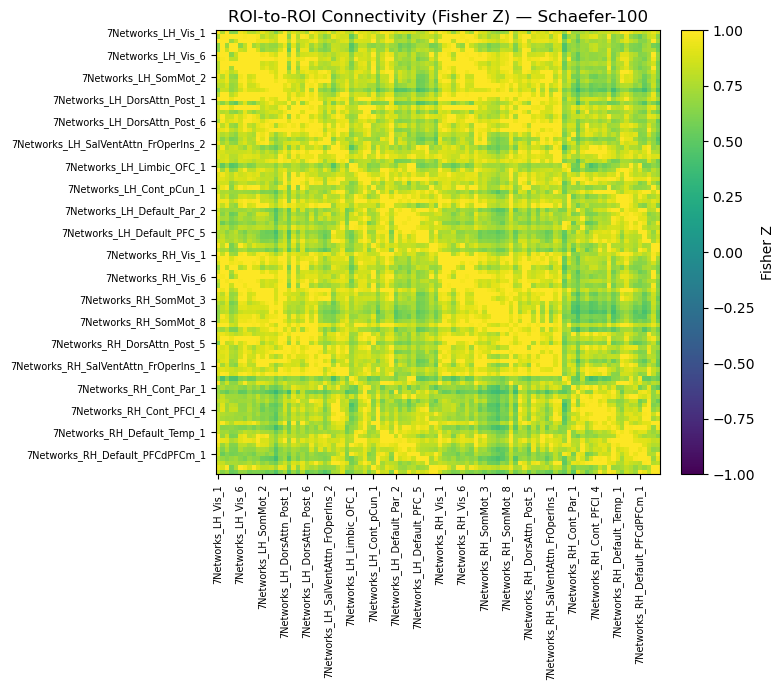

In [8]:
# Labeled DataFrame (Fisher Z)
z_df = pd.DataFrame(z_avg, index=roi_names, columns=roi_names)
display(z_df)  # optional peek

# Heatmap (tick thinning so labels remain readable)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(z_df.values, vmin=-1, vmax=1, interpolation='nearest')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Fisher Z', rotation=90)

ax.set_title('ROI-to-ROI Connectivity (Fisher Z) — Schaefer-100')

step  = max(1, z_df.shape[0] // 20)  # ~≤20 ticks to avoid clutter
ticks = np.arange(0, z_df.shape[0], step)
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_xticklabels([roi_names[i] for i in ticks], rotation=90, fontsize=7)
ax.set_yticklabels([roi_names[i] for i in ticks], fontsize=7)

plt.tight_layout()
plt.show()

# Optional: save for reports
# z_df.to_csv('sub-02_Schaefer100_FC_Z.csv', index=True)

---

# **2 Seed-Based Correlation (voxelwise)**

**Idea:** choose a seed (e.g., a sphere around an MNI peak), extract its time series, correlate with every voxel.

* **What it does:**

  * Pick a **seed region** (sphere or atlas ROI).
  * Extract its time series.
  * Correlate with **every voxel in the brain**.

* **Output:**
  A **3D map** (seed correlation map).

  * Each voxel value = correlation with the seed.
  * Visualize as a statistical brain map.

* **Usefulness:**
  Good for identifying **networks connected to one seed** (e.g. DMN from PCC seed).

## 2.1) Define the seed (spherical ROI in MNI space)

**Why:** choose a seed location and radius to summarize a small region’s time series.

In [8]:
from nilearn.maskers import NiftiSpheresMasker

# Example: ACC seed (replace with your coordinate or a GLM peak)
seed_xyz    = (0, 24, 30)   # MNI mm
seed_radius = 6.0           # mm

seed_masker1 = NiftiSpheresMasker([seed_xyz], radius=seed_radius,
                                  standardize=True, detrend=True, t_r=TR1)
seed_masker2 = NiftiSpheresMasker([seed_xyz], radius=seed_radius,
                                  standardize=True, detrend=True, t_r=TR2)

# Seed time series (confounds regressed at extraction)
seed_ts1 = seed_masker1.fit_transform(img1, confounds=conf1).ravel()  # shape (T1,)
seed_ts2 = seed_masker2.fit_transform(img2, confounds=conf2).ravel()  # shape (T2,)
seed_ts1.shape

e:\anaconda\envs\neuroimaging\Lib\site-packages\joblib\memory.py:326: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
e:\anaconda\envs\neuroimaging\Lib\site-packages\joblib\memory.py:326: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(146,)

## 2.2) Extract whole-brain voxelwise signals (denoised)

**Why:** we need a time series for **every voxel** to correlate with the seed.

In [10]:
from nilearn.maskers import NiftiMasker

wb_masker1 = NiftiMasker(standardize=True, detrend=True, t_r=TR1)
wb_masker2 = NiftiMasker(standardize=True, detrend=True, t_r=TR2)

# 2D arrays: time × voxels
X1 = wb_masker1.fit_transform(img1, confounds=conf1)  # (T1, V)
X2 = wb_masker2.fit_transform(img2, confounds=conf2)  # (T2, V)
X1.shape

(146, 592848)


## 2.3) Compute voxelwise correlations (seed ↔ voxel)

**Why:** quantify how each voxel co-fluctuates with the seed.
**Note:** with standardized columns, Pearson r = dot(z-scored seed, z-scored voxel) / (T-1).

In [11]:
# z-score seed series (safe if already standardized; this keeps it explicit)
seed_ts1_z = (seed_ts1 - seed_ts1.mean()) / seed_ts1.std()
seed_ts2_z = (seed_ts2 - seed_ts2.mean()) / seed_ts2.std()

# Fast vectorized correlation with all voxels
corr_vx1 = (seed_ts1_z @ X1) / (X1.shape[0] - 1)  # (V,)
corr_vx2 = (seed_ts2_z @ X2) / (X2.shape[0] - 1)  # (V,)

corr_vx1.shape

(592848,)

## 2.4) Fisher Z-transform and combine runs

**Why:** `arctanh(r)` normalizes correlations → valid averaging across runs; back-transform with `tanh` if you need r.

In [12]:
# Avoid ±1 → inf after arctanh
corr_vx1 = np.clip(corr_vx1, -0.999999, 0.999999)
corr_vx2 = np.clip(corr_vx2, -0.999999, 0.999999)

z_vx1 = np.arctanh(corr_vx1)
z_vx2 = np.arctanh(corr_vx2)

# Back to NIfTI in Z-space
from nilearn import image
zmap_seed1 = wb_masker1.inverse_transform(z_vx1)
zmap_seed2 = wb_masker2.inverse_transform(z_vx2)

# Fixed-effect average across runs in Z-space
zmap_seed_avg = image.mean_img([zmap_seed1, zmap_seed2])

# Optional: convert to r for display/reporting
# rmap_seed_avg = image.math_img("tanh(img)", img=zmap_seed_avg)

zmap_seed_avg.shape

C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\3558038609.py:14: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  zmap_seed_avg = image.mean_img([zmap_seed1, zmap_seed2])


(79, 95, 79)

## 2.5) Visualize seed map (unthresholded, then display threshold)

**Why:** unthresholded maps show full pattern; a light display threshold makes the network easier to see.

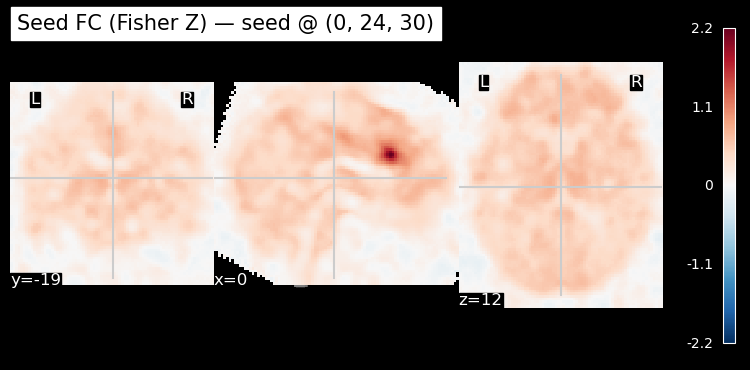

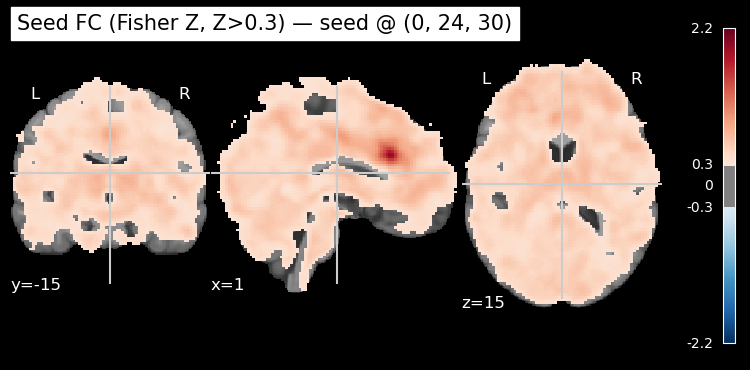

In [13]:
from nilearn import plotting, datasets

# Background anatomy
bg = datasets.load_mni152_template()  # or fetch_icbm152_2009()['t1'] on older versions

# Unthresholded (for QC / pedagogy)
plotting.plot_stat_map(zmap_seed_avg, bg_img=bg, display_mode='ortho',
                       title=f"Seed FC (Fisher Z) — seed @ {seed_xyz}",
                       symmetric_cbar=True)

# Gentle uncorrected display threshold to highlight pattern (adjust to taste)
plotting.plot_stat_map(zmap_seed_avg, bg_img=bg, display_mode='ortho',
                       threshold=0.3,  # Fisher Z threshold (uncorrected)
                       title=f"Seed FC (Fisher Z, Z>0.3) — seed @ {seed_xyz}",
                       symmetric_cbar=True)
plotting.show()

## 2.6)  Statistical thresholding (FDR or cluster)

**Why:** if you want inferential control (beyond a display cutoff), use FDR/cluster-based thresholding.


Seed FC Z-map: max Z = 2.197, 95th |Z| = 0.594, 99th |Z| = 0.699


C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\3923138595.py:20: UserWarning: The given float value must not exceed 2.196577548980713. But, you have given threshold=inf.
  thr_img, thr = thresholding.threshold_stats_img(


FDR empty → using display cutoff |Z| > 0.64


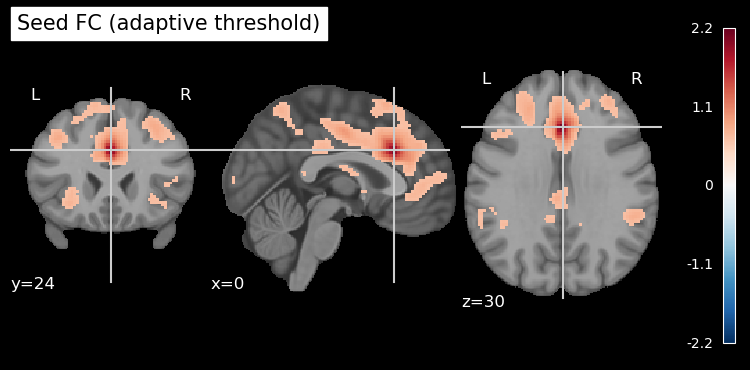

In [14]:
# --- STEP 6: Statistical / display thresholding for the seed Z-map ---

import numpy as np
from nilearn.glm import thresholding
from nilearn import plotting, datasets

# background anatomy (pick the one that works for your Nilearn)
bg = datasets.load_mni152_template()
# icbm = datasets.fetch_icbm152_2009(); bg = icbm['t1']  # if needed

# 6.1) summarize the unthresholded Z-map
zdata = np.nan_to_num(zmap_seed_avg.get_fdata(), copy=False)
zabs  = np.abs(zdata)
zmax  = float(zdata.max())
p95   = float(np.percentile(zabs, 95))
p99   = float(np.percentile(zabs, 99))
print(f"Seed FC Z-map: max Z = {zmax:.3f}, 95th |Z| = {p95:.3f}, 99th |Z| = {p99:.3f}")

# 6.2) try voxelwise FDR (two-sided). Let Nilearn choose the cutoff.
thr_img, thr = thresholding.threshold_stats_img(
    zmap_seed_avg,
    alpha=0.05,
    height_control='fdr',
    two_sided=True
)
has_voxels = np.any(np.nan_to_num(thr_img.get_fdata(), copy=False))

# 6.3) if FDR is empty, use a percentile-based display cutoff (e.g., 97.5th |Z|)
if not has_voxels:
    disp_thr = float(np.percentile(zabs, 97.5))
    print(f"FDR empty → using display cutoff |Z| > {disp_thr:.2f}")
    thr_img, _ = thresholding.threshold_stats_img(
        zmap_seed_avg,
        height_control=None,          # display threshold (no voxelwise correction)
        two_sided=True,
        threshold=disp_thr,
        cluster_threshold=5           # small k so something shows up
    )
    has_voxels = np.any(np.nan_to_num(thr_img.get_fdata(), copy=False))

# 6.4) still empty? ensure a minimal non-empty display (very gentle cutoff)
if not has_voxels:
    fallback_thr = min(0.5, max(0.1, 0.25 * zmax))  # clamp between 0.1 and 0.5
    print(f"Still empty → fallback display cutoff |Z| > {fallback_thr:.2f}")
    thr_img, _ = thresholding.threshold_stats_img(
        zmap_seed_avg,
        height_control=None,
        two_sided=True,
        threshold=fallback_thr,
        cluster_threshold=0
    )

# 6.5) plot the thresholded map (auto-centre on a non-empty cut)
coords = plotting.find_xyz_cut_coords(thr_img)
plotting.plot_stat_map(
    thr_img, bg_img=bg, display_mode='ortho', cut_coords=coords,
    symmetric_cbar=True, title="Seed FC (adaptive threshold)"
)
plotting.show()


## 2.7) Atlas-guided summary of “connected regions”

**Why:** summarize voxel map into named ROIs for reporting (counts/%ROI).

* **What it does:**

  * Start from a **seed Z-map** (voxelwise correlations).
  * Threshold it (e.g. keep voxels Z > 0.5).
  * Count how many suprathreshold voxels fall into each ROI of an atlas.

* **Output:**
  A **ranked table** of ROIs (labels + voxel counts, % of ROI).

* **Usefulness:**
  Bridges voxelwise maps back to **anatomical labels** → interpretable results (“seed X connects mostly to regions Y and Z”).

In [ ]:
# Resample atlas to the zmap space, threshold the zmap (e.g., Z>0.5)
atlas_resamp = image.resample_to_img(atlas_img, zmap_seed_avg, interpolation='nearest')
zdata   = zmap_seed_avg.get_fdata()
zmask   = (zdata > 0.64)  
atlas_d = atlas_resamp.get_fdata().astype(int)

rows = []
roi_ids = np.unique(atlas_d); roi_ids = roi_ids[roi_ids > 0]
for rid in roi_ids:
    roi_mask = (atlas_d == rid)
    count = int(np.sum(zmask & roi_mask))
    if count > 0:
        label = str(atlas_labels[rid]) if rid < len(atlas_labels) else f"ROI_{rid}"
        rows.append((rid, label, count))

connected_df = pd.DataFrame(rows, columns=['roi_id','label','n_voxels']) \
                .sort_values('n_voxels', ascending=False)
display(connected_df.head(20))

C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\187353010.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resamp = image.resample_to_img(atlas_img, zmap_seed_avg, interpolation='nearest')
C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\187353010.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_resamp = image.resample_to_img(atlas_img, zmap_seed_avg, interpolation='nearest')


,roi_id,label,n_voxels
27,28,7Networks_LH_SalVentAttn_Med_1,1492
45,46,7Networks_LH_Default_PFC_5,1426
96,97,7Networks_RH_Default_PFCdPFCm_2,1245
87,88,7Networks_RH_Cont_PFCmp_1,1215
26,27,7Networks_LH_SalVentAttn_PFCl_1,1181
75,76,7Networks_RH_SalVentAttn_FrOperIns_1,1175
84,85,7Networks_RH_Cont_PFCl_3,1075
95,96,7Networks_RH_Default_PFCdPFCm_1,1024
85,86,7Networks_RH_Cont_PFCl_4,1016
34,35,7Networks_LH_Cont_PFCl_1,1000


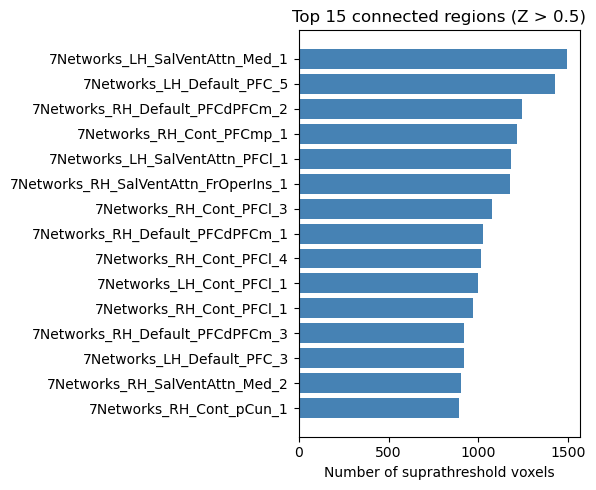

C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\3445401535.py:25: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  top_mask_img = image.new_img_like(zmap_seed_avg, top_mask_data.astype(int))


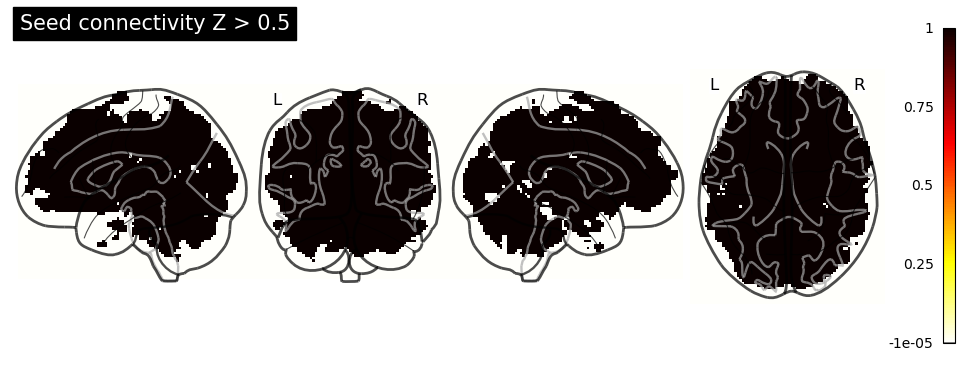

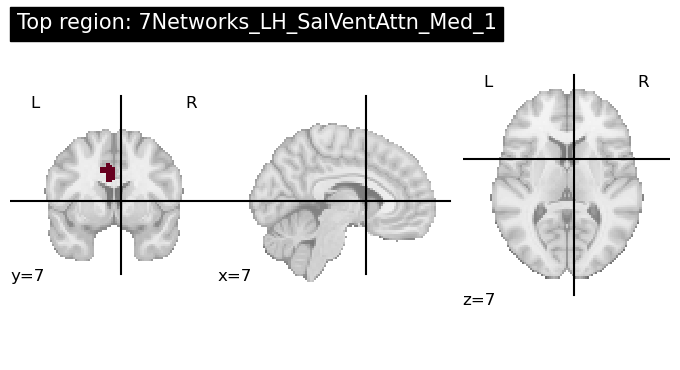

In [ ]:
# Threshold with NumPy, then create an image with the same header/affine
thr = 0.64
zmask_data = (zmap_seed_avg.get_fdata() > thr)
z_thr_img = image.new_img_like(zmap_seed_avg, zmask_data.astype(np.uint8))

atlas_data = atlas_resamp.get_fdata().astype(int)
# --- 2) Horizontal bar plot of top N regions ---
topN = 15
top_df = connected_df.head(topN).sort_values('n_voxels')

plt.figure(figsize=(6, 5))
plt.barh(top_df['label'], top_df['n_voxels'], color='steelblue')
plt.xlabel("Number of suprathreshold voxels")
plt.title(f"Top {topN} connected regions (Z > {thr})")
plt.tight_layout()
plt.show()

# --- 3) Glass brain view of the whole thresholded connectivity map ---
plotting.plot_glass_brain(z_thr_img, display_mode='lyrz',
                          colorbar=True, title=f'Seed connectivity Z > {thr}')

# --- 4) Optional: show just the top region mask ---
top_roi = int(top_df.iloc[-1]['roi_id'])  # ROI id of top region
top_mask_data = (atlas_data == top_roi) & zmask_data
top_mask_img = image.new_img_like(zmap_seed_avg, top_mask_data.astype(int))

plotting.plot_stat_map(top_mask_img, title=f"Top region: {top_df.iloc[-1]['label']}",
                       cut_coords=[7,7,7], colorbar=False)
plotting.show()

---



*  Overlay the **top N atlas regions** (those with the most suprathreshold voxels) as **colored contours** on top of your **thresholded seed FC map**.

* **Inputs it expects already defined:**
  `connected_df` (sorted by `n_voxels` desc), `z_thr_img` (thresholded Z-map),
  `atlas_data` (atlas in the z-map space), `zmask_data` (boolean mask of suprathreshold voxels),
  `zmap_seed_avg` (unthresholded seed Z-map for header/affine).

* **What it does step by step:**

  1. Picks the **top N** rows from `connected_df` (most “connected” ROIs).
  2. Shows a **glass-brain** of the thresholded seed map (`z_thr_img`) for anatomical context.
  3. Assigns **distinct colors** using `tab10` (easy-to-read palette).
  4. For each ROI:

     * Builds a **binary mask** of voxels that are both in the ROI and suprathreshold (`(atlas_data == roi_id) & zmask_data`).
     * Adds the ROI’s **contour** to the display in its unique color.
  5. Creates a **legend** mapping contour colors to ROI labels, placed **below** the figure to avoid overlap.

* **Result:** A single figure where your thresholded seed connectivity is visible, with the **top N connected regions outlined** in different colors and neatly **labeled** in a legend.


---

# **3) Advanced Options (task-specific FC)**

## **3.1. Beta-Series Connectivity (event-related designs)**

**Idea:** estimate one **beta per trial** (trial-wise GLM), then correlate those betas across ROIs.

**Standard task GLM vs. Beta-Series Connectivity (BSC)**

In a standard task GLM, the *regressor* is a time series (0/1 blocks or sticks convolved with the HRF), but the **beta is one single coefficient per regressor per voxel for the whole run**:

[
$$
y(t)=\beta_{\text{cond}},x_{\text{cond}}(t)+\beta_{\text{nuis}},x_{\text{nuis}}(t)+\epsilon(t)
$$
]
$$
So if you model “Condition A” with **one regressor**, you get **one per voxel/ROI (per run): $$(\beta_{\text{A}})$$** . There is no: $$(\beta(t))$$.

### What changes in trial-wise GLM (and why BSC needs it)

Beta-series connectivity is defined as: **“estimate one beta per trial, then correlate those betas across ROIs.”** 

To make a *series* of betas, you must have **many observations** to correlate. Trial-wise GLM creates that by giving **each trial its own regressor**, producing:

* ROI A: $$([\beta_{A,1}, \beta_{A,2}, \ldots, \beta_{A,N}])$$
* ROI B: $$([\beta_{B,1}, \beta_{B,2}, \ldots, \beta_{B,N}])$$

Then you correlate the two vectors. 

### Why you *cannot* do BSC with classic condition betas

If you do the “classic” GLM with one regressor per condition, you get:

* ROI A: $$(\beta_{A,\text{cond}}) (one number)$$
* ROI B: $$(\beta_{B,\text{cond}}) (one number)$$

With only **one paired value**, there is nothing to correlate. That’s the core reason.

In a **standard task GLM**, each condition is typically modeled with **one regressor per condition** (per run). The output is **one beta per voxel/ROI per condition**—a single number that summarizes the **average task-evoked response** for that condition across the whole run. Because you only have one beta value per condition (per ROI), you **cannot compute a correlation “within a subject” between ROIs using those condition betas**—there is no *series* of observations to correlate.

In **Beta-Series Connectivity (BSC)**, we change the GLM so that we estimate **one beta per trial** (or per block, if modeled separately). This creates a **beta series** for each ROI: $$([\beta_1, \beta_2, …, \beta_N])$$. We then compute connectivity by correlating the beta series between ROIs. BSC therefore measures **trial-to-trial (or block-to-block) coupling**: when ROI A responds more strongly on a particular trial, does ROI B also respond more strongly on that same trial?

**Bottom line:** 

Standard GLM betas answer “How much does this condition activate the region on average?” 

BSC answers “Do regions’ responses co-vary across trials/blocks?” 


### 3.1.1) Define ROIs (Atlas-based)

**Why:** BSC will summarize **trial-wise betas** inside ROIs to compute ROI↔ROI connectivity.

In [6]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

# Example: Schaefer-100 atlas (if you don’t have one loaded yet)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
atlas_img    = schaefer['maps']
atlas_labels = schaefer['labels']

# Masker to average each beta-map within ROI labels (no temporal params needed here)
roi_masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True)


### 3.1.2) Build **trial-wise events** (one regressor per trial)

**Why:** In BSC, each trial is modeled with its **own** regressor. After GLM, you get **one beta image per trial**, which you then correlate **across trials**.

In [20]:
# Copy the cleaned events and give each trial a unique name
ev1_bs = events1_clean.copy()
ev2_bs = events2_clean.copy()
ev1_bs['trial_type'] = [f"trial_{i:04d}" for i in range(len(ev1_bs))]
ev2_bs['trial_type'] = [f"trial_{i:04d}" for i in range(len(ev2_bs))]

# (Optional) Restrict to a condition for *condition-specific* BSC, e.g. only incongruent
# ev1_bs = ev1_bs.query("original_condition == 'incongruent'")  # if you kept a column like this
# ev2_bs = ev2_bs.query("original_condition == 'incongruent'")

In [21]:
ev2_bs

,onset,duration,trial_type
0,0.0,2.0,trial_0000
1,10.0,2.0,trial_0001
2,20.0,2.0,trial_0002
3,32.0,2.0,trial_0003
4,44.0,2.0,trial_0004
5,54.0,2.0,trial_0005
6,64.0,2.0,trial_0006
7,76.0,2.0,trial_0007
8,88.0,2.0,trial_0008
9,102.0,2.0,trial_0009


> 💡 *Tip:* If you need **per-condition** BSC, create **trial labels per condition**, then compute and compare connectivity matrices across conditions.

### 3.1.3) Fit **trial-wise GLM** per run

**Why:** The GLM estimates a **beta map per trial** (effect of that trial’s stick regressor after HRF convolution and confound regression).

In [9]:
from nilearn.glm.first_level import FirstLevelModel

m1_bs = FirstLevelModel(
    t_r=TR1, hrf_model='spm', drift_model='cosine',
    high_pass=0.008, noise_model='ols'
).fit(img1, events=ev1_bs, confounds=conf1)

m2_bs = FirstLevelModel(
    t_r=TR2, hrf_model='spm', drift_model='cosine',
    high_pass=0.008, noise_model='ols'
).fit(img2, events=ev2_bs, confounds=conf2)

In [24]:
dm=m1_bs.design_matrices_[0]
dm

,trial_0000,trial_0001,trial_0002,trial_0003,trial_0004,trial_0005,trial_0006,trial_0007,trial_0008,trial_0009,...,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2,drift_1,drift_2,drift_3,drift_4,constant
0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.117034,0.117014,0.116980,0.116933,1.0
2.0,0.019130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000009,0.000529,1.468272e-07,9.475147e-08,1.536598e-08,0.116980,0.116797,0.116493,0.116067,1.0
4.0,0.235975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002342,0.000975,1.625497e-06,7.217520e-08,3.181994e-09,0.116872,0.116364,0.115520,0.114342,1.0
6.0,0.407753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000981,0.000054,6.193610e-08,7.745739e-08,2.652410e-09,0.116709,0.115716,0.114067,0.111770,1.0
8.0,0.305191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002613,0.000790,2.475429e-07,1.227758e-07,1.927738e-07,0.116493,0.114853,0.112138,0.108371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000488,0.004536,8.169797e-07,3.538575e-08,1.701230e-07,-0.116493,0.114853,-0.112138,0.108371,1.0
284.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004522,0.000018,4.988060e-09,2.069076e-07,1.888876e-09,-0.116709,0.115716,-0.114067,0.111770,1.0
286.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004998,0.000091,1.525568e-08,1.489574e-08,1.430232e-07,-0.116872,0.116364,-0.115520,0.114342,1.0
288.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001611,0.000225,2.752927e-07,4.658833e-08,6.221687e-08,-0.116980,0.116797,-0.116493,0.116067,1.0


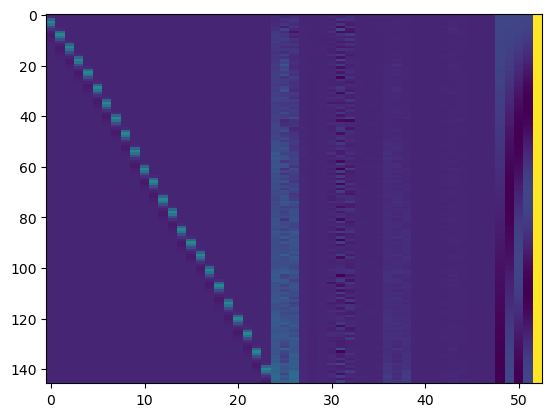

In [25]:
plt.imshow(dm.to_numpy(dtype=float), aspect='auto', interpolation='nearest')

In [23]:
print(m1_bs.design_matrices_[0]['trial_0001'])

0.0      0.0
2.0      0.0
4.0      0.0
6.0      0.0
8.0      0.0
        ... 
282.0    0.0
284.0    0.0
286.0    0.0
288.0    0.0
290.0    0.0
Name: trial_0001, Length: 146, dtype: float64



### 3.1.4) Get **one beta image per trial**

**Why:** These are your **trial features**. We’ll summarize them per ROI, then correlate across trials.

In [10]:
# Select only the trial regressors (skip drifts/confounds/intercept)
trial_cols_run1 = [c for c in m1_bs.design_matrices_[0].columns if c.startswith('trial_')]
trial_cols_run2 = [c for c in m2_bs.design_matrices_[0].columns if c.startswith('trial_')]

# Compute effect-size (beta) images for every trial
beta_imgs_run1 = [m1_bs.compute_contrast(name, output_type='effect_size') for name in trial_cols_run1]
beta_imgs_run2 = [m2_bs.compute_contrast(name, output_type='effect_size') for name in trial_cols_run2]

In [16]:
trial_cols_run1

['trial_0000',
 'trial_0001',
 'trial_0002',
 'trial_0003',
 'trial_0004',
 'trial_0005',
 'trial_0006',
 'trial_0007',
 'trial_0008',
 'trial_0009',
 'trial_0010',
 'trial_0011',
 'trial_0012',
 'trial_0013',
 'trial_0014',
 'trial_0015',
 'trial_0016',
 'trial_0017',
 'trial_0018',
 'trial_0019',
 'trial_0020',
 'trial_0021',
 'trial_0022',
 'trial_0023']

In [15]:
beta_imgs_run2

In [13]:
len(beta_imgs_run1)

24

In [14]:
beta_imgs_run1[0].shape

(79, 95, 79, 1)

### 3.1.5) Extract **ROI betas** (trial × ROI) and compute BSC

**Why:** For each trial, average the beta map within each ROI → a matrix of size **n\_trials × n\_rois**.
Then compute a **correlation across trials** between ROI columns → **ROI×ROI connectivity**.

In [26]:
# Trial-wise beta series per ROI (rows=trials, cols=ROIs)
B1 = np.vstack([roi_masker.fit_transform(b) for b in beta_imgs_run1])  # (n_trials1, n_rois)
B2 = np.vstack([roi_masker.fit_transform(b) for b in beta_imgs_run2])  # (n_trials2, n_rois)

# Correlate ROIs across trials (within each run)
corr_bs1 = np.corrcoef(B1, rowvar=False)  # (n_rois, n_rois)
corr_bs2 = np.corrcoef(B2, rowvar=False)

# Fisher Z-transform for normality and cross-run averaging
z1 = np.arctanh(np.clip(corr_bs1, -0.999999, 0.999999))
z2 = np.arctanh(np.clip(corr_bs2, -0.999999, 0.999999))
z_bs = (z1 + z2) / 2.0                      # fixed-effect average (within-subject)
r_bs = np.tanh(z_bs)                         # back to r if needed for interpretation

e:\anaconda\envs\neuroimaging\Lib\site-packages\nilearn\signal.py:64: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


In [27]:
B1.shape

(24, 100)

In [28]:
r_bs.shape

(100, 100)

> 📌 *Interpretation:* BSC answers *“which ROIs covary in their trial-wise responses?”*
> It’s **task-specific** because those trial betas come from a GLM that modeled your events.


### 3.1.6) Visualize the **Beta-Series FC matrix**

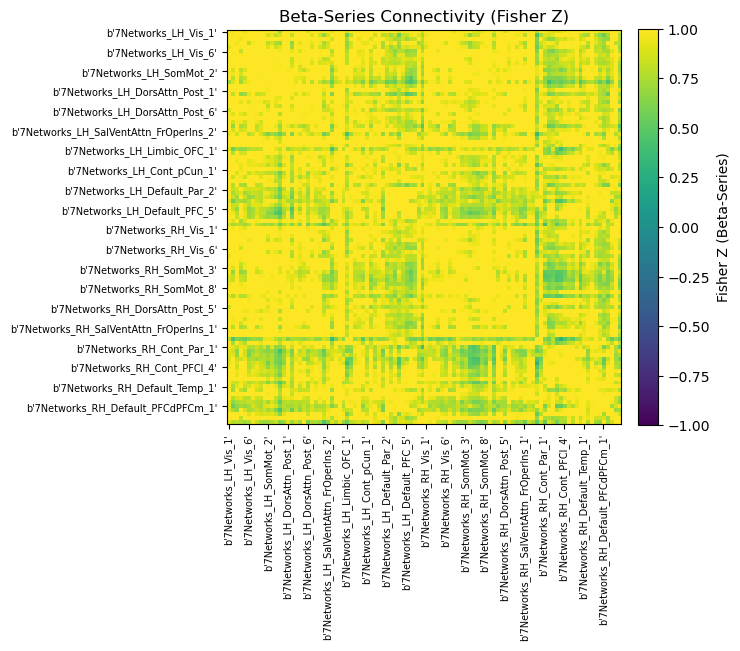

In [29]:

fig, ax = plt.subplots(figsize=(7.5, 7))
im = ax.imshow(z_bs, vmin=-1, vmax=1, interpolation='nearest')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Fisher Z (Beta-Series)', rotation=90)
ax.set_title('Beta-Series Connectivity (Fisher Z)')

# (Optional) add ROI tick labels if you have atlas_labels (thin to avoid clutter)
roi_names = [str(l) for l in atlas_labels]
step = max(1, len(roi_names) // 20)
ticks = np.arange(0, len(roi_names), step)
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_xticklabels([roi_names[i] for i in ticks], rotation=90, fontsize=7)
ax.set_yticklabels([roi_names[i] for i in ticks], fontsize=7)

plt.tight_layout(); plt.show()

### 3.1.7) (Optional) **Per-condition** BSC (compare connectivity)

**Why:** Test whether connectivity differs between conditions (e.g., *incongruent* vs *congruent*).

**How to do it cleanly:**

* Build **separate trial lists** per condition (e.g., `trial_inc_*` vs `trial_cong_*`).
* Compute two BSC matrices (`z_bs_inc`, `z_bs_cong`).
* Compare them (difference map, ROI-wise tests at group level).

In [ ]:
# Example skeleton (requires you to have condition info per trial)
# inc_cols1 = [c for c in trial_cols_run1 if 'inc' in c]   # adapt filter to your naming
# cong_cols1 = [c for c in trial_cols_run1 if 'cong' in c]
# beta_inc_run1  = [m1_bs.compute_contrast(c, output_type='effect_size') for c in inc_cols1]
# beta_cong_run1 = [m1_bs.compute_contrast(c, output_type='effect_size') for c in cong_cols1]
# ... repeat for run 2, extract ROI matrices, build corr->Z, average across runs.
# z_diff = z_bs_inc - z_bs_cong   # within-subject difference to take to group stats

> 🧪 For **group inference**, collect each subject’s `z_bs` (or condition-specific `z_bs`) and run ROI-wise stats (t-tests/GLMs) across subjects, correcting for multiple comparisons.


# 3.1.8) (FYI) PPI vs BSC — where they differ

* **BSC:** trial-wise GLM → one beta per trial → **correlate betas** across trials.
  *Great for event-related designs; captures trial-by-trial coupling.*

* **PPI:** single GLM with **three regressors**:
  (1) psychological (task regressor), (2) physiological (seed time series), (3) **interaction** (psych×phys).
  Test the **interaction** term: *connectivity changes with task*.
  *Great when you want explicit modulation of seed connectivity by condition.*

Minimal PPI snippet (already aligned with your earlier pipeline):

## Practical tips / QC

* **Enough trials:** BSC needs a reasonable number of trials (per condition if you split).
* **Collinearity:** trial regressors must be estimable (short ISIs can hurt).
* **Masker standardization:** keep `standardize=True` for ROI betas.
* **Fisher Z:** always average/connectivity-stats in Z space; convert back with `tanh` only for display.
* **Reporting:** number of trials, TR, model settings, confounds, atlas, thresholding/corrections.

---


## **3.2. PPI (psychophysiological interaction)**

**Idea:** add **seed**, **psychological** (task), and **interaction (seed × task)** regressors to a GLM; the interaction’s beta tests **task-modulated connectivity**.
(Formal PPI does deconvolution/reconvolution; this is a common simplified version.)

### 3.2.1) Psychological regressor from the design

**why:** PPI needs a **task regressor** (e.g., *incongruent*), convolved with the HRF, sampled at your TR.

In [4]:
# frame times
n_scans_1 = img1.shape[-1]; frame_times_1 = np.arange(n_scans_1) * TR1
n_scans_2 = img2.shape[-1]; frame_times_2 = np.arange(n_scans_2) * TR2

# build task-only designs (drifts added by nilearn)
dm_task1 = make_first_level_design_matrix(frame_times_1, events1_clean,
                                          hrf_model='spm', drift_model='cosine', high_pass=0.008)
dm_task2 = make_first_level_design_matrix(frame_times_2, events2_clean,
                                          hrf_model='spm', drift_model='cosine', high_pass=0.008)

# pick the condition column (edit the name if yours differs)
psych1 = dm_task1['incongruent'].to_numpy()
psych2 = dm_task2['incongruent'].to_numpy()

In [5]:
dm_task1

,congruent,incongruent,drift_1,drift_2,drift_3,drift_4,constant
0.0,0.000000,0.000000,0.117034,0.117014,0.116980,0.116933,1.0
2.0,0.019130,0.000000,0.116980,0.116797,0.116493,0.116067,1.0
4.0,0.235975,0.000000,0.116872,0.116364,0.115520,0.114342,1.0
6.0,0.407753,0.000000,0.116709,0.115716,0.114067,0.111770,1.0
8.0,0.305191,0.000000,0.116493,0.114853,0.112138,0.108371,1.0
...,...,...,...,...,...,...,...
282.0,-0.015884,0.305191,-0.116493,0.114853,-0.112138,0.108371,1.0
284.0,-0.008488,0.141690,-0.116709,0.115716,-0.114067,0.111770,1.0
286.0,-0.004039,0.034974,-0.116872,0.116364,-0.115520,0.114342,1.0
288.0,-0.001744,-0.017274,-0.116980,0.116797,-0.116493,0.116067,1.0


In [6]:
psych1

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.91303520e-02,  2.35974864e-01,
        4.07752852e-01,  3.05190584e-01,  1.41690394e-01,  3.49742488e-02,
       -1.72738717e-02, -3.56745324e-02, -3.48666299e-02, -2.57968901e-02,
        3.24587475e-03,  2.27486698e-01,  4.03713489e-01,  3.03446807e-01,
        1.40997802e-01,  5.38516061e-02,  2.18700992e-01,  3.72078319e-01,
        2.70323955e-01,  1.15893504e-01,  1.90897716e-02, -2.57620373e-02,
       -3.97138951e-02, -3.66104076e-02, -2.64894828e-02, -1.61374720e-02,
       -8.48816557e-03, -4.03936270e-03, -1.74377774e-03, -6.92592623e-04,
       -2.52994730e-04,  0.00000000e+00,  0.00000000e+00,  1.91303520e-02,
        2.35974864e-01,  4.07752852e-01,  3.05190584e-01,  1.41690394e-01,
        3.49742488e-02,  1.85648025e-03,  2.00300331e-01,  3.72886222e-01,
        2.79393694e-01,  1.25805917e-01,  2.64860832e-02, -2.13132344e-02,
       -1.82879582e-02,  

### 3.2.2) Build the PPI regressor (interaction)

**why:** classic PPI tests whether connectivity between the seed and the rest of the brain **changes with task**.
best practice is to **demean / standardize** both series before multiplying to reduce collinearity.

In [10]:
# center-and-scale (z-score) the seed and psych series
seed1_z = (seed_ts1 - seed_ts1.mean()) / seed_ts1.std()
seed2_z = (seed_ts2 - seed_ts2.mean()) / seed_ts2.std()
psych1_z = (psych1   - psych1.mean())   / psych1.std()
psych2_z = (psych2   - psych2.mean())   / psych2.std()

# interaction term
ppi1 = seed1_z * psych1_z
ppi2 = seed2_z * psych2_z

ppi1

array([-1.22306629e-01, -4.08571702e-01,  1.17955578e+00,  1.28172967e+00,
        1.09494770e+00,  2.03969707e+00,  1.11811439e+00, -1.43542454e+00,
       -3.86231301e+00,  7.92310648e-01,  2.47629148e-01, -2.96589477e-01,
       -1.07440935e+00, -1.76956277e+00, -2.86172320e+00, -1.86379954e+00,
       -5.48050811e-01,  1.98104377e+00,  5.21629181e+00,  2.36831928e+00,
       -1.29075341e-01,  1.41406432e-01, -1.25415497e+00, -1.22450024e+00,
       -1.62714923e+00,  3.15138352e-01, -1.51138034e-01,  6.44440818e-01,
       -6.07500888e-01, -3.69618171e-01, -5.51877284e-01, -2.58270971e-01,
        2.87413443e-01, -6.59241191e-01, -5.75233890e-01, -3.95575207e-01,
       -1.15688878e+00, -7.30227812e-04,  3.06584723e-01,  4.04999273e-01,
       -8.81120651e-01,  1.18381034e+00,  1.71047152e+00, -1.06330586e-01,
        4.67814250e-02,  1.71786559e-01,  3.39529053e-01,  2.33219858e+00,
       -4.47137524e-01,  2.74446884e-01,  7.02375784e-01,  1.55412705e-01,
        3.74993834e-01, -


> note: this is the standard (convolved) PPI formulation. deconvolved (neural-level) PPI variants exist but are not required for most use cases in nilearn tutorials.

### 3.2.3) Fit GLM with seed + psych + PPI in **confounds**

**why:** we include the **seed** and **psych** main effects so the **ppi** contrast captures *task-dependent* coupling, not main effects.

In [12]:
# augment confounds with seed/psych/ppi (motion/aCompCor/etc. are already in conf1/conf2)
conf1_ppi = conf1.copy().assign(seed=seed1_z, psych=psych1_z, ppi=ppi1)
conf2_ppi = conf2.copy().assign(seed=seed2_z, psych=psych2_z, ppi=ppi2)

# fit per run (events = original task events)
m1_ppi = FirstLevelModel(t_r=TR1, hrf_model='spm', drift_model='cosine',
                         high_pass=0.008, noise_model='ols') \
         .fit(img1, events=events1_clean, confounds=conf1_ppi)

m2_ppi = FirstLevelModel(t_r=TR2, hrf_model='spm', drift_model='cosine',
                         high_pass=0.008, noise_model='ols') \
         .fit(img2, events=events2_clean, confounds=conf2_ppi)

# the test of interest: the PPI regressor
z_ppi1 = m1_ppi.compute_contrast("ppi", output_type='z_score')
z_ppi2 = m2_ppi.compute_contrast("ppi", output_type='z_score')

conf1_ppi

e:\anaconda\envs\neuroimaging\Lib\site-packages\nilearn\glm\_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
e:\anaconda\envs\neuroimaging\Lib\site-packages\nilearn\glm\_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,...,rot_z_power2,trans_x_derivative1_power2,trans_y_derivative1_power2,trans_z_derivative1_power2,rot_x_derivative1_power2,rot_y_derivative1_power2,rot_z_derivative1_power2,seed,psych,ppi
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.200943,-0.608664,-0.122307
1,0.017953,-0.002970,0.023004,-0.000383,0.000308,0.000124,0.017953,-0.002970,0.023004,-0.000383,...,1.536598e-08,0.000322,0.000009,0.000529,1.468272e-07,9.475147e-08,1.536598e-08,0.671260,-0.608664,-0.408572
2,0.009020,0.045421,0.054231,0.000892,0.000039,0.000180,-0.008933,0.048391,0.031228,0.001275,...,3.253289e-08,0.000080,0.002342,0.000975,1.625497e-06,7.217520e-08,3.181994e-09,-1.937943,-0.608664,1.179556
3,0.018050,0.014094,0.046858,0.000643,-0.000239,0.000129,0.009030,-0.031327,-0.007374,-0.000249,...,1.660676e-08,0.000082,0.000981,0.000054,6.193610e-08,7.745739e-08,2.652410e-09,-2.105809,-0.608664,1.281730
4,0.019934,0.065208,0.018757,0.001140,0.000111,0.000568,0.001884,0.051114,-0.028100,0.000498,...,3.225415e-07,0.000004,0.002613,0.000790,2.475429e-07,1.227758e-07,1.927738e-07,-1.798937,-0.608664,1.094948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.225636,0.183858,0.259000,0.007580,-0.004437,0.001919,-0.016602,0.022094,0.067353,-0.000904,...,3.680870e-06,0.000276,0.000488,0.004536,8.169797e-07,3.538575e-08,1.701230e-07,0.763687,1.634246,1.248053
142,0.247124,0.116611,0.263228,0.007510,-0.003982,0.001875,0.021488,-0.067248,0.004228,-0.000071,...,3.515993e-06,0.000462,0.004522,0.000018,4.988060e-09,2.069076e-07,1.888876e-09,0.880224,0.432649,0.380828
143,0.266763,0.187306,0.272780,0.007633,-0.004104,0.002253,0.019640,0.070696,0.009552,0.000124,...,5.077281e-06,0.000386,0.004998,0.000091,1.525568e-08,1.489574e-08,1.430232e-07,0.751495,-0.351631,-0.264249
144,0.255501,0.147164,0.257765,0.008158,-0.004320,0.002004,-0.011262,-0.040142,-0.015015,0.000525,...,4.015411e-06,0.000127,0.001611,0.000225,2.752927e-07,4.658833e-08,6.221687e-08,1.053948,-0.735613,-0.775298


In [14]:
dm_ppi=m1_ppi.design_matrices_[0]
dm_ppi


,congruent,incongruent,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,trans_x_derivative1,trans_y_derivative1,...,rot_y_derivative1_power2,rot_z_derivative1_power2,seed,psych,ppi,drift_1,drift_2,drift_3,drift_4,constant
0.0,-3.030807e-16,1.272961e-15,-3.058171e-15,-1.841545e-15,-2.192586e-15,-1.381332e-15,3.399544e-16,1.145839e-15,-7.725106e-17,6.715554e-16,...,-1.406184e-15,-1.674411e-16,0.200943,-0.608664,-0.122307,0.117034,0.117014,0.116980,0.116933,1.0
2.0,1.913035e-02,-1.056372e-14,1.795251e-02,-2.969906e-03,2.300380e-02,-3.831804e-04,3.078173e-04,1.239596e-04,1.795251e-02,-2.969906e-03,...,9.475147e-08,1.536598e-08,0.671260,-0.608664,-0.408572,0.116980,0.116797,0.116493,0.116067,1.0
4.0,2.359749e-01,2.110922e-15,9.019883e-03,4.542105e-02,5.423142e-02,8.917692e-04,3.916284e-05,1.803688e-04,-8.932623e-03,4.839095e-02,...,7.217520e-08,3.181993e-09,-1.937943,-0.608664,1.179556,0.116872,0.116364,0.115520,0.114342,1.0
6.0,4.077529e-01,-1.991677e-16,1.804984e-02,1.409366e-02,4.685751e-02,6.428995e-04,-2.391488e-04,1.288672e-04,9.029953e-03,-3.132739e-02,...,7.745739e-08,2.652409e-09,-2.105809,-0.608664,1.281730,0.116709,0.115716,0.114067,0.111770,1.0
8.0,3.051906e-01,7.996391e-16,1.993370e-02,6.520815e-02,1.875732e-02,1.140436e-03,1.112449e-04,5.679274e-04,1.883864e-03,5.111449e-02,...,1.227758e-07,1.927738e-07,-1.798937,-0.608664,1.094948,0.116493,0.114853,0.112138,0.108371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282.0,-1.588448e-02,3.051906e-01,2.256357e-01,1.838585e-01,2.590000e-01,7.580127e-03,-4.436569e-03,1.918559e-03,-1.660249e-02,2.209447e-02,...,3.538575e-08,1.701230e-07,0.763687,1.634246,1.248053,-0.116493,0.114853,-0.112138,0.108371,1.0
284.0,-8.488166e-03,1.416904e-01,2.471238e-01,1.166107e-01,2.632279e-01,7.509501e-03,-3.981698e-03,1.875098e-03,2.148815e-02,-6.724778e-02,...,2.069076e-07,1.888875e-09,0.880224,0.432649,0.380828,-0.116709,0.115716,-0.114067,0.111770,1.0
286.0,-4.039363e-03,3.497425e-02,2.667634e-01,1.873065e-01,2.727798e-01,7.633015e-03,-4.103746e-03,2.253282e-03,1.963957e-02,7.069578e-02,...,1.489574e-08,1.430232e-07,0.751495,-0.351631,-0.264249,-0.116872,0.116364,-0.115520,0.114342,1.0
288.0,-1.743778e-03,-1.727387e-02,2.555010e-01,1.471644e-01,2.577649e-01,8.157698e-03,-4.319590e-03,2.003849e-03,-1.126239e-02,-4.014204e-02,...,4.658833e-08,6.221687e-08,1.053948,-0.735613,-0.775298,-0.116980,0.116797,-0.116493,0.116067,1.0


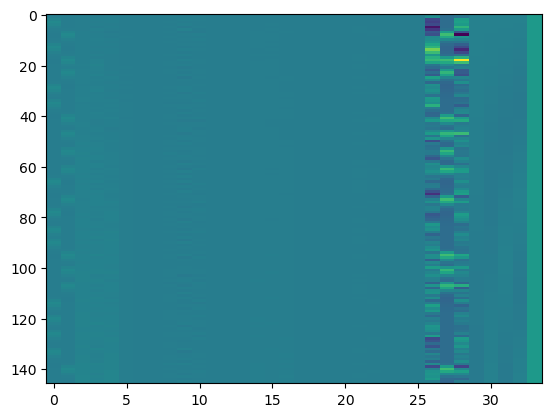

In [15]:
plt.imshow(dm_ppi.to_numpy(dtype=float), aspect='auto', interpolation='nearest')

### 3.2.4) Thresholding (FDR first, then cluster display if empty)

**why:** prefer data-driven FDR for inference; if nothing survives (common with short runs), show a **cluster display** so patterns are still visible for QC.

C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\181969109.py:4: UserWarning: The given float value must not exceed 3.996374247322329. But, you have given threshold=inf.
  thr_img1, thr1 = thresholding.threshold_stats_img(z_ppi1, alpha=0.05, height_control='fdr', two_sided=True)
C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\181969109.py:5: UserWarning: The given float value must not exceed 4.180395837576669. But, you have given threshold=inf.
  thr_img2, thr2 = thresholding.threshold_stats_img(z_ppi2, alpha=0.05, height_control='fdr', two_sided=True)


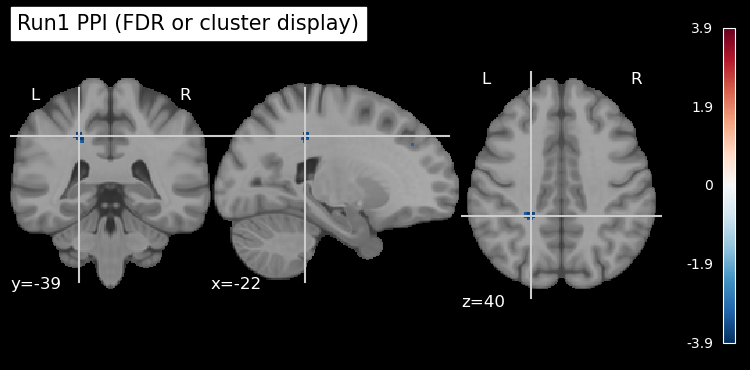

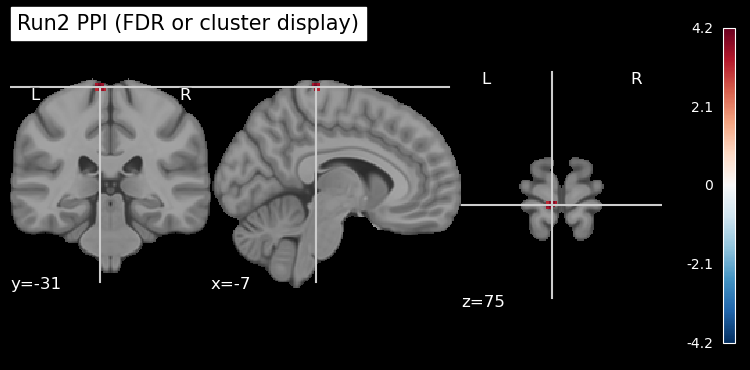

In [28]:

bg = datasets.load_mni152_template()

# try two-sided voxelwise FDR
thr_img1, thr1 = thresholding.threshold_stats_img(z_ppi1, alpha=0.05, height_control='fdr', two_sided=True)
thr_img2, thr2 = thresholding.threshold_stats_img(z_ppi2, alpha=0.05, height_control='fdr', two_sided=True)

def is_empty(img):
    return not np.any(np.nan_to_num(img.get_fdata(), copy=False))

if is_empty(thr_img1):
    thr_img1, _ = thresholding.threshold_stats_img(
        z_ppi1, height_control=None, threshold=3.1, two_sided=True, cluster_threshold=10
    )
if is_empty(thr_img2):
    thr_img2, _ = thresholding.threshold_stats_img(
        z_ppi2, height_control=None, threshold=3.1, two_sided=True, cluster_threshold=10
    )

# plot
coords1 = plotting.find_xyz_cut_coords(thr_img1)
coords2 = plotting.find_xyz_cut_coords(thr_img2)
plotting.plot_stat_map(thr_img1, bg_img=bg, display_mode='ortho', cut_coords=coords1,
                       symmetric_cbar=True, title='Run1 PPI (FDR or cluster display)')
plotting.plot_stat_map(thr_img2, bg_img=bg, display_mode='ortho', cut_coords=coords2,
                       symmetric_cbar=True, title='Run2 PPI (FDR or cluster display)')
plotting.show()


### 3.2.5) (optional) Combine runs within subject (fixed effects)

C:\Users\Saye\AppData\Local\Temp\ipykernel_19376\1351774070.py:9: DeprecationWarning: The behavior of this function will be changed in release 0.13 to have an additional return value 'fixed_fx_z_score_img' by default. Please set return_z_score to True.
  fx_eff, fx_var, fx_z = compute_fixed_effects([eff1, eff2], [var1, var2], mask=None)


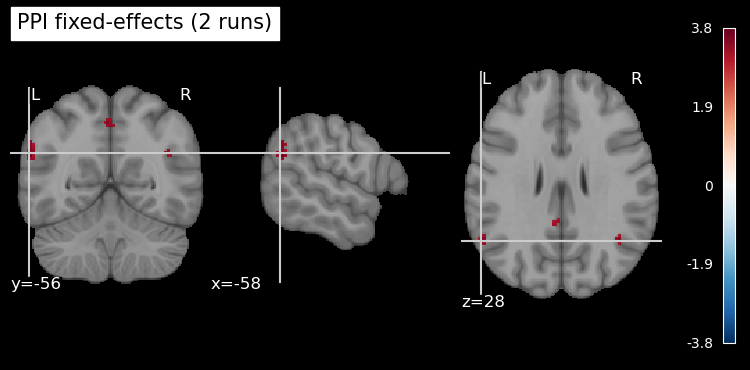

In [29]:
from nilearn.glm.contrasts import compute_fixed_effects

# also keep effect size / variance if you plan to combine properly
eff1 = m1_ppi.compute_contrast("ppi", output_type='effect_size')
var1 = m1_ppi.compute_contrast("ppi", output_type='effect_variance')
eff2 = m2_ppi.compute_contrast("ppi", output_type='effect_size')
var2 = m2_ppi.compute_contrast("ppi", output_type='effect_variance')

fx_eff, fx_var, fx_z = compute_fixed_effects([eff1, eff2], [var1, var2], mask=None)

thr_fx, _ = thresholding.threshold_stats_img(
    fx_z, height_control=None, threshold=3.1, two_sided=True, cluster_threshold=10
)
coords_fx = plotting.find_xyz_cut_coords(thr_fx)
plotting.plot_stat_map(thr_fx, bg_img=bg, display_mode='ortho', cut_coords=coords_fx,
                       symmetric_cbar=True, title='PPI fixed-effects (2 runs)')
plotting.show()



## notes & interpretation

* **center/standardize** seed & psych before forming `ppi` to reduce collinearity and stabilize estimates.
* **contrast on `'ppi'`** asks: *does seed connectivity increase/decrease when the psychological regressor is “on” vs “off” (after HRF convolution and controlling for seed & psych main effects)?*
* **two-sided vs one-sided:** keep two-sided for inference unless you have strong a-priori direction.
* **deconvolution variants:** some pipelines form PPI in neural space (deconvolve seed, multiply with un-convolved psych, reconvolve). nilearn examples typically use the convolved version above, which is widely used and simpler.
* **group level:** export subject-level PPI z-maps (or effect/variance) to second-level GLMs exactly like standard activation contrasts.


C:\Users\Saye\AppData\Local\Temp\ipykernel_16324\2204545693.py:33: UserWarning: Matrix is singular at working precision, regularizing...
  noise_model='ar1').fit(img1,
C:\Users\Saye\AppData\Local\Temp\ipykernel_16324\2204545693.py:38: UserWarning: Matrix is singular at working precision, regularizing...
  noise_model='ar1').fit(img2,


Run1 PPI cluster-forming threshold (Z>3.1): 1.9599639845400545
Run2 PPI cluster-forming threshold (Z>3.1): 1.9599639845400545


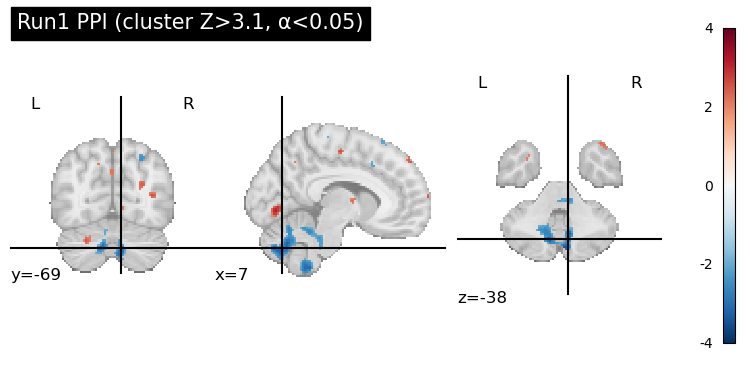

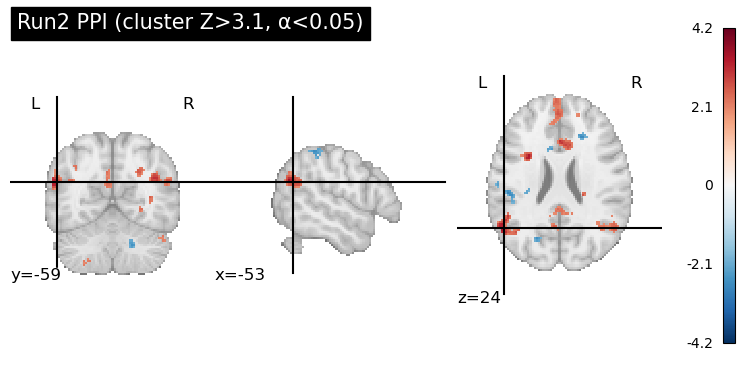

In [ ]:
'''
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import thresholding
from nilearn import plotting
import numpy as np

# --- get seed time series already computed: seed_ts1, seed_ts2 ---

# --- psychological regressor (binary stick for 'incongruent') ---
n_scans_1 = img1.shape[-1]; frame_times_1 = np.arange(n_scans_1) * TR1
n_scans_2 = img2.shape[-1]; frame_times_2 = np.arange(n_scans_2) * TR2

dm_task1 = make_first_level_design_matrix(frame_times_1, events1_clean,
                                          hrf_model='spm', drift_model='cosine',
                                          high_pass=0.008)
dm_task2 = make_first_level_design_matrix(frame_times_2, events2_clean,
                                          hrf_model='spm', drift_model='cosine',
                                          high_pass=0.008)

psych1 = dm_task1['incongruent'].to_numpy()
psych2 = dm_task2['incongruent'].to_numpy()

# --- interaction term (PPI regressor) ---
ppi1 = seed_ts1 * psych1
ppi2 = seed_ts2 * psych2

# --- build confound tables with seed + psych + ppi ---
conf1_ppi = conf1.copy().assign(seed=seed_ts1, psych=psych1, ppi=ppi1)
conf2_ppi = conf2.copy().assign(seed=seed_ts2, psych=psych2, ppi=ppi2)

# --- fit GLM and compute PPI contrast ---
m1_ppi = FirstLevelModel(t_r=TR1, hrf_model='spm',
                         drift_model='cosine', high_pass=0.008,
                         noise_model='ar1').fit(img1,
                                                events=events1_clean,
                                                confounds=conf1_ppi)
m2_ppi = FirstLevelModel(t_r=TR2, hrf_model='spm',
                         drift_model='cosine', high_pass=0.008,
                         noise_model='ar1').fit(img2,
                                                events=events2_clean,
                                                confounds=conf2_ppi)

z_ppi1 = m1_ppi.compute_contrast("ppi", output_type='z_score')
z_ppi2 = m2_ppi.compute_contrast("ppi", output_type='z_score')

# --- cluster-based thresholding ---
# voxelwise Z > 3.1 (~p<0.001) and cluster-level correction at alpha=0.05
thr_img1, threshold1 = thresholding.threshold_stats_img(
    z_ppi1, alpha=0.05, height_control='fpr',
    cluster_threshold=10, two_sided=True, threshold=3.1
)

thr_img2, threshold2 = thresholding.threshold_stats_img(
    z_ppi2, alpha=0.05, height_control='fpr',
    cluster_threshold=10, two_sided=True, threshold=3.1
)

print("Run1 PPI cluster-forming threshold (Z>3.1):", threshold1)
print("Run2 PPI cluster-forming threshold (Z>3.1):", threshold2)

# --- plot thresholded maps ---
plotting.plot_stat_map(thr_img1, title='Run1 PPI (cluster Z>3.1, α<0.05)')
plotting.plot_stat_map(thr_img2, title='Run2 PPI (cluster Z>3.1, α<0.05)')
plotting.show()
'''

> Note: formal PPI uses deconvolution of the seed to neural space before interaction; libraries differ. For teaching, this simplified template shows the core idea.



---
---

# **Final Overview**



# 1. GLM & First-Level Model

* **What is it?**
  The **general linear model (GLM)** in fMRI is used for **activation analysis**.
  You model the BOLD time series at each voxel as:

  $$
  Y(t) = X(t)\beta + \epsilon(t)
  $$

  * $Y(t)$ = voxel time series
  * $X(t)$ = design matrix (task regressors, confounds)
  * $\beta$ = estimated weights (activation strength)
  * $\epsilon$ = noise

* **Why use it?**
  To test whether a voxel (or ROI) shows significant *activation* for a certain condition (e.g., incongruent > congruent).

* **Where it lives in Nilearn?**
  [`FirstLevelModel`](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) → handles:

  * design matrix construction,
  * fitting betas,
  * computing contrasts → **statistical maps** (z, t, beta maps).

👉 **Bottom line:** GLM = *model-driven*, hypothesis testing about mean activity differences.

---

# 2. Functional Connectivity & ConnectivityMeasure

* **What is it?**
  FC measures the **statistical dependency between regions’ time series** — usually correlations.

  * ROI-to-ROI FC: correlation matrix
  * Seed-based FC: correlation map

* **Why use it?**
  To capture *network structure* and *temporal coupling*, not activation strength.

* **Where it lives in Nilearn?**
  [`ConnectivityMeasure`](https://nilearn.github.io/stable/modules/generated/nilearn.connectome.ConnectivityMeasure.html) → takes time series from ROIs and computes:

  * correlation, partial correlation, covariance, tangent, etc.

👉 **Bottom line:** FC = *data-driven*, descriptive statistics of synchrony.

---

# 3. Why we didn’t use `FirstLevelModel` in ROI-to-ROI or seed FC

* In your connectivity analysis, you already had **preprocessed runs** (denoised with confounds).
* You extracted **time series** directly (via `NiftiLabelsMasker` or `NiftiSpheresMasker`).
* Then you computed **correlations** → that’s what `ConnectivityMeasure` does.
* No design matrix was needed, because you weren’t testing “task vs baseline” but just asking “how correlated are these signals across time?”

That’s why GLM didn’t appear in those FC sections.

---

# 4. How GLM and FC fit together in a pipeline

* **Step 1 — GLM (First Level)**
  Run per-subject GLMs to localize task activations (statistical contrasts).
  → E.g., find incongruent > congruent regions.

* **Step 2 — Use GLM results to guide FC**

  * pick **seeds** from GLM peaks for seed-based FC,
  * or test task-modulated FC with **beta-series connectivity** or **PPI** (which *do* combine GLM with FC).

* **Step 3 — Pure FC (ConnectivityMeasure)**
  Describe the network structure (ROI correlations, graph measures).

---

✅ So in your notebook:

* **GLM / FirstLevelModel**: for activation maps & contrasts.
* **ConnectivityMeasure**: for correlation-based FC, when you just want ROI synchrony.
* **Both together**: advanced FC (beta-series, PPI) — these explicitly combine GLM modeling with connectivity analysis.

---





# 🔄 fMRI Analysis: GLM vs Functional Connectivity

```
         ┌─────────────────────────┐
         │  Preprocessed fMRI data │
         │  (BOLD runs, confounds) │
         └────────────┬────────────┘
                      │
      ┌───────────────┼────────────────┐
      │                                │
      ▼                                ▼
┌───────────────┐               ┌────────────────────┐
│  GLM / First- │               │ Functional         │
│  Level Model  │               │ Connectivity (FC)  │
└───────────────┘               └────────────────────┘
        │                                │
        │                                │
        ▼                                ▼
 ┌───────────────┐                ┌─────────────────────┐
 │ Design Matrix │                │ ROI / Seed Time     │
 │ (task, HRF,   │                │ Series Extraction   │
 │ confounds)    │                │ (masker)            │
 └───────────────┘                └─────────────────────┘
        │                                │
        ▼                                ▼
 ┌───────────────┐                ┌─────────────────────┐
 │ Beta maps     │                │ Correlation /       │
 │ Contrast maps │                │ Covariance matrices │
 │ Z/T maps      │                │ (ConnectivityMeasure)│
 └───────────────┘                └─────────────────────┘
        │                                │
        ▼                                ▼
 ┌───────────────┐                ┌─────────────────────┐
 │ "Activation"  │                │ "Synchrony"         │
 │ (where BOLD   │                │ (which regions are  │
 │ ↑/↓ per task) │                │ coupled over time)  │
 └───────────────┘                └─────────────────────┘
```

---

# 🧩 How They Connect

* **GLM (FirstLevelModel):**

  * Tests **mean differences** in BOLD responses.
  * Needs **design matrix** (task regressors convolved with HRF).
  * Output: statistical maps (β, z, t).
  * Interpretation: *Activation strength for condition A vs B.*

* **Functional Connectivity (ConnectivityMeasure):**

  * Tests **temporal correlation** between regions’ time series.
  * No design matrix → task-free (resting) or residual/task-period restricted.
  * Output: correlation matrices, seed maps.
  * Interpretation: *How strongly regions co-fluctuate over time.*

* **Advanced bridges:**

  * **Beta-series connectivity**: GLM produces one beta per trial → correlate across ROIs.
  * **PPI (psychophysiological interaction)**: GLM with interaction term between seed and task → task-modulated FC.

---

# 📝 Rule of Thumb 

* **Use GLM** when: you want to answer *“which voxels/ROIs are activated by my task?”*
* **Use ConnectivityMeasure** when: you want to answer *“how do regions talk to each other?”*
* **Use PPI or beta-series** when: you want *task-specific connectivity* (bridge between activation and FC).

---






## Is GLM an essenyial step for calculating basic functional connectivity?

**No — a GLM is not an essential step for calculating *basic functional connectivity*.**

* **Basic FC** = correlations between time series (ROI↔ROI or seed↔voxel).
* You just need *preprocessed BOLD signals* (denoised, standardized).
* You do **not** need a design matrix or contrasts.

That’s why in Nilearn we used `ConnectivityMeasure` and `NiftiMasker` directly, without `FirstLevelModel`.

---

## ✅ But when is GLM involved in FC?

GLM *does* enter the picture in **advanced / task-modulated FC approaches**:

1. **Beta-Series Connectivity**

   * GLM estimates **one beta per trial**.
   * Then you correlate betas across ROIs → FC that depends on trial-by-trial responses.
   * Used in event-related designs.

2. **Psychophysiological Interaction (PPI)**

   * GLM with regressors:

     * Seed time series (physiological)
     * Task condition (psychological)
     * Seed × task interaction (PPI)
   * The interaction beta = “connectivity changes with task.”

👉 In both, the GLM provides a *framework to model condition-specific connectivity*, rather than plain correlations.

---

## 🎯 Rule of thumb 

* **Resting-state FC** → **No GLM needed**. Just extract time series + correlate.
* **Task-based FC (vanilla)** → Often still **no GLM**: you can compute correlations across the whole run or within conditions.
* **Task-modulated FC (Beta-series, PPI)** → **GLM required**, because you need trial-by-trial or interaction terms.

---

🔑 So: **GLM is essential for activation analysis and advanced FC (beta-series, PPI), but not for plain correlation-based FC.**

---
